# H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001)

We illustrate a simple workflow with the driven and damped qubit example studied in - H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001).

## Setup and Configuration

First, we need to ensure our optimized Numba functions work correctly.

In [1]:
# Fix for the sqrt_jit type signature issue
import numpy as np
import sys
import os

# Path to the usual_operators.py file
operators_path = os.path.join(os.path.dirname(os.getcwd()), 'qt_unraveling', 'usual_operators.py')

# Patch the sqrt_jit function if using the optimized version
with open(operators_path, 'r') as f:
    content = f.read()

if '@njit(complex128[:,:](complex128[:,:]), fastmath=True, cache=True)' in content:
    print("Fixing sqrt_jit type signature...")
    updated_content = content.replace(
        '@njit(complex128[:,:](complex128[:,:]), fastmath=True, cache=True)',
        '@njit(fastmath=True, cache=True)'
    )
    with open(operators_path, 'w') as f:
        f.write(updated_content)
    print("sqrt_jit function fixed!")
else:
    print("No fix needed for sqrt_jit function.")

No fix needed for sqrt_jit function.


In [2]:
## 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import numpy as np
from numba import jit, njit

## Library
import qt_unraveling as qtr

In [3]:
import numba
numba.__version__

'0.61.2'

In [4]:
## Opitonal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

In [5]:
## Parameters 
gamma = 1
omega = 10

## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## Initial state 
initialState = np.array([1,1], dtype = np.complex128) ## Pure state
# initialState = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C') ## Mixed state

## Lindblad operators
L = np.sqrt(gamma)*np.array([qtr.sigmam], dtype=np.complex128)

# Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
# ## Fixed unraveling
u_matrix = np.eye(np.shape(L)[0], dtype=np.complex128)
# h_matrix = 0.5*np.eye(np.shape(L)[0], dtype=np.complex128)

## Ortogonal freedom
# theta = 0
# oMatrix = np.array([[np.cos(theta), -np.sin(theta)],
#                   [np.sin(theta), np.cos(theta)]])

In [6]:
# # You have the option to define an adaptive unraveling. This is done by defining it in term of a function of t and the state
# # ## Adapative unraveling
# @njit
# def u_matrix(t, rho):
#     num_op = 1
#     uM = np.zeros((num_op,num_op), dtype=np.complex128)
#     uM[0,0] = -np.trace(np.dot(rho,qtr.sigmam))/np.trace(np.dot(rho,qtr.sigmap))
#     return uM

In [7]:
## Time parameters
t0 = 0
tf = 10
time_steps = 30000
dt = int(abs(tf-t0)/time_steps)

## Time range
timelist = np.linspace(t0, tf, np.int32(time_steps))

## Basic functionalities

This library is based on two main unraveling schemes: quantum jump (QJump) and diffusive schemes. The following shows how you can use the basic functionalities of this library. You can start by using the System class, which gives support to every unraveling method on the library:

In [8]:
%%time
## System definitionsetup_lindblad_operators
qtr_test = qtr.QuantumSystem(H0, initialState, timelist, lindbladList = L, uMatrix = u_matrix)

CPU times: user 11.3 ms, sys: 1 ms, total: 12.3 ms
Wall time: 11.1 ms


/home/deo/Documents/PhD/qt-unraveling-python/qt_unraveling/qt_unraveling.py:58: UserWarning: Initial state is unnormalized. Normalized state taken instead
  warnings.warn('Initial state is unnormalized. Normalized state taken instead')


### Unitary evolution

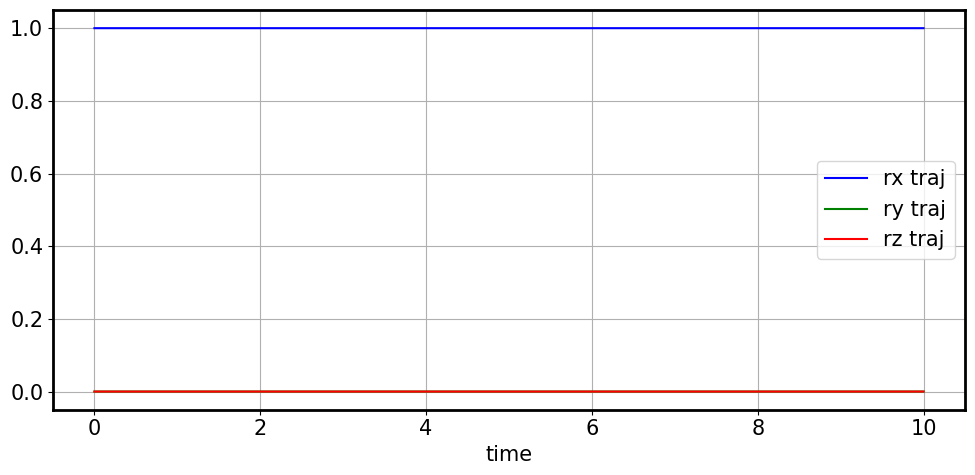

In [9]:
## Von Neumann evolution
unitary_evol = qtr_test.vonneumann_analytical()

# Von Neumann plot
qtr.misc.rhoBlochcomp_plot(unitary_evol, qtr_test.timeList, label='traj')
plt.tight_layout()

### Diffusive trajectory

In [10]:
%%time
## Average conditional diffusive evoltuion
rho_diff = qtr_test.diffusive_methods.diffusive_rho_average(n_trajectories=1, method='euler')

CPU times: user 16.2 ms, sys: 106 ms, total: 122 ms
Wall time: 320 ms


In [11]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindblad_analytical()

CPU times: user 142 ms, sys: 3.08 ms, total: 145 ms
Wall time: 153 ms


(-1.1, 1.1)

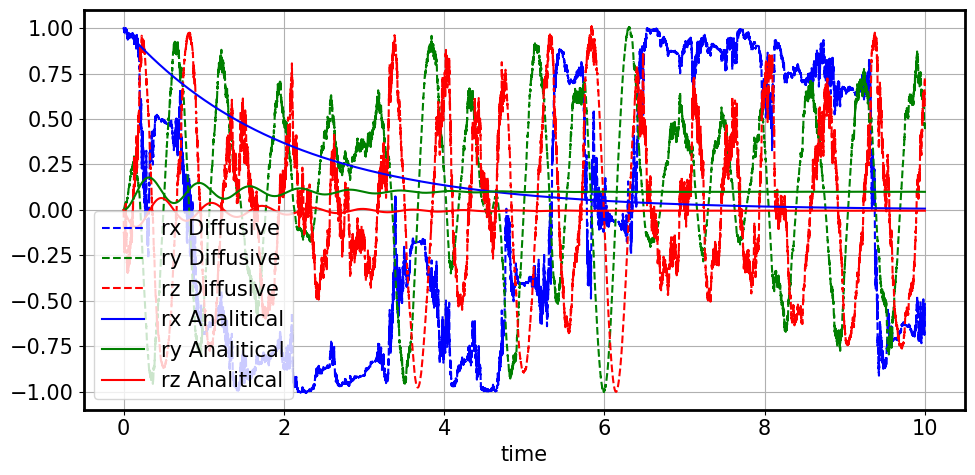

In [12]:
## Diffusive plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_diff, qtr_test.timeList, label='Diffusive', line='--', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()
plt.ylim(-1.1, 1.1)

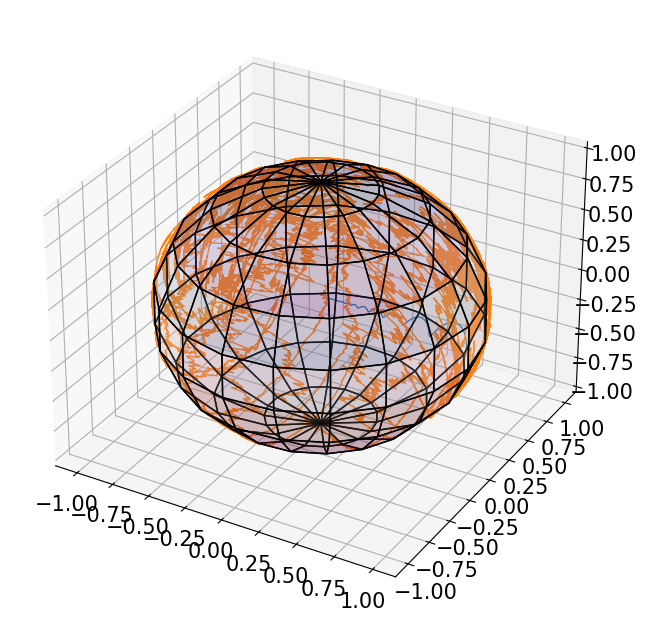

In [13]:
qtr.misc.rhoBlochSphere([lindblad_evol, rho_diff])

### Jump trajectory

In [14]:
%%time
## Average conditional Qjump evoltuion
coherent_fields = np.array([0.01,0.01], dtype=np.complex128)
rho_qjump = qtr_test.jumpy_methods.jump_rho_average(n_trajectories=1, coherent_fields=coherent_fields)

CPU times: user 12.1 ms, sys: 114 ms, total: 127 ms
Wall time: 1.45 s


In [15]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindblad_analytical()

CPU times: user 167 ms, sys: 4.48 ms, total: 172 ms
Wall time: 183 ms


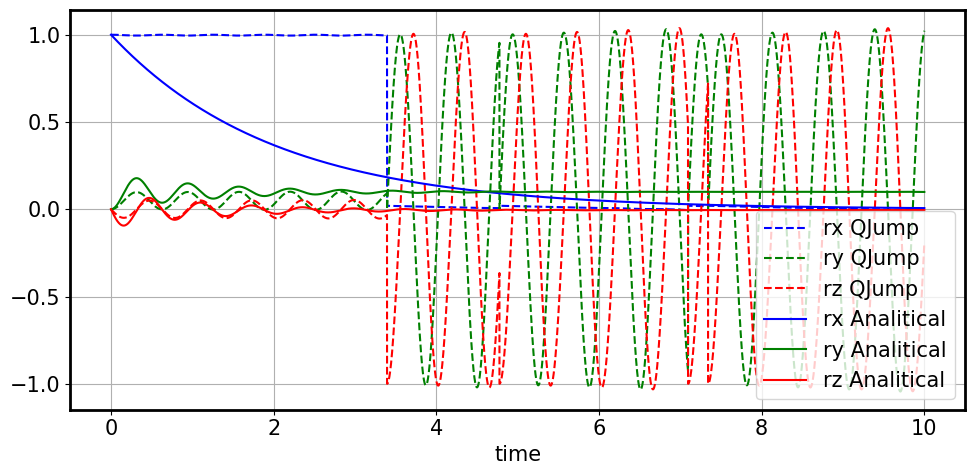

In [16]:
## Qjump plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_qjump, qtr_test.timeList, label='QJump', line='--', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()

### Quantum jump connection to the diffusive unraveling

The Qjump methods are equiped with an unraveling option that allows us to explore the continous limit of the this scheme

In [17]:
%%time
## Large coherent field mu and small time step dt
coherent_fields = np.array([5,5], dtype=np.complex128)
qjump_coh_traj = qtr_test.jumpy_methods.jump_rho_trajectory(coherent_fields=coherent_fields, seed=5)

CPU times: user 3.67 s, sys: 75 ms, total: 3.74 s
Wall time: 3.84 s


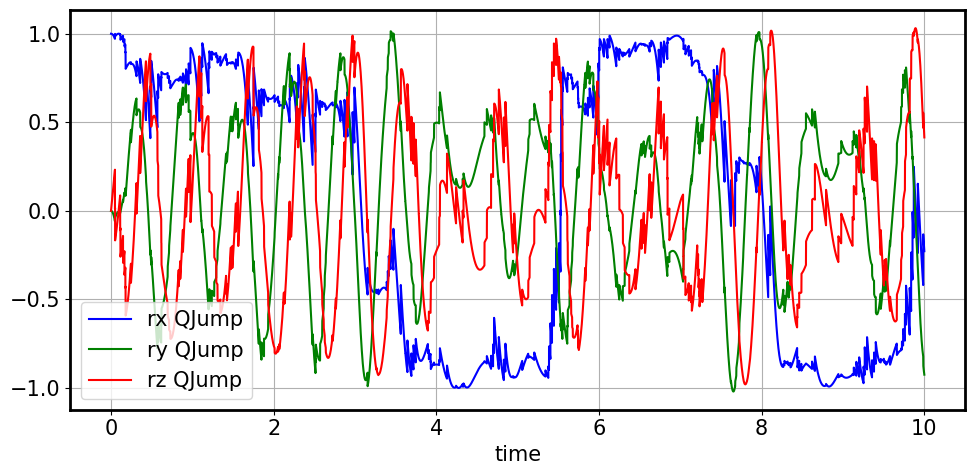

In [18]:
## Jump trajectory
qtr.misc.rhoBlochcomp_plot(qjump_coh_traj, qtr_test.timeList, label='QJump', line='-')
plt.tight_layout()

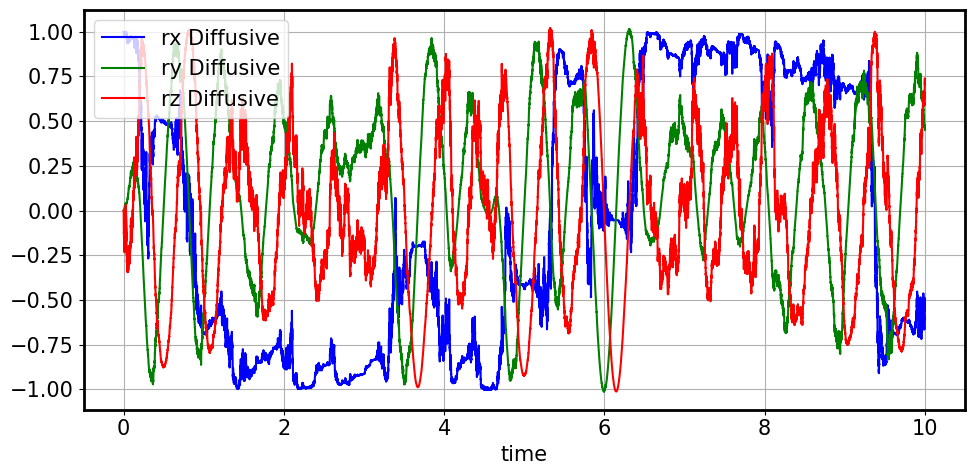

In [19]:
## Diffusive trajectory
rho_diffusive = qtr_test.diffusive_methods.diffusive_rho_trajectory(method='milstein')

## Diffusive plot
qtr.misc.rhoBlochcomp_plot(rho_diffusive, qtr_test.timeList, label='Diffusive', line='-')
plt.tight_layout()

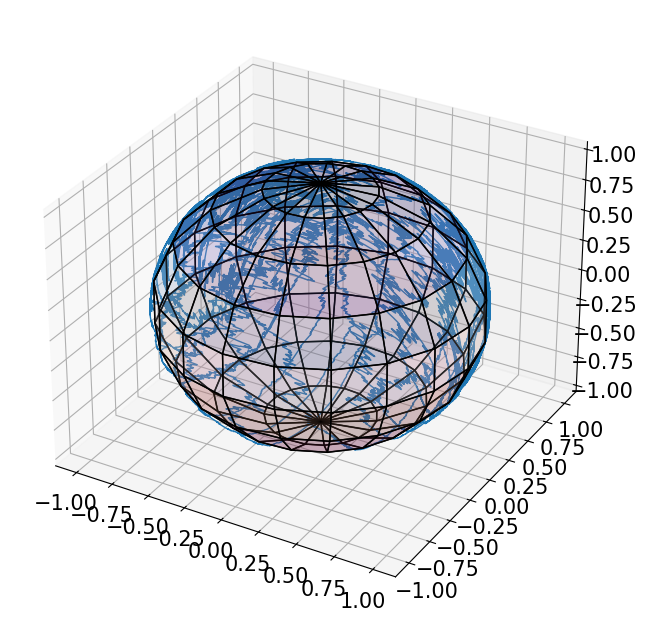

In [20]:
qtr.misc.rhoBlochSphere([rho_diffusive])

### Quantum Feedback processes

An application of the diffusive scheme is the possibility of feeding back the continuos currents via an extra term in the system Hamiltonian as described in [[1]](https://arxiv.org/abs/1102.3098). Each feedbcak operator corerspond to a Hermitian operator that describe the feedback action on the system. Our library is capable of implementing this processes as follows

In [111]:
## Parameters 
gamma = 1
omega = 10

## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## Time parameters
t0 = 0
tf = 10
time_steps = 30000

## Time range
timelist = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
initialState = np.array([1,1], dtype = np.complex128) ## Pure state
# initialState = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C') ## Mixed state

## Lindblad operators
L = np.sqrt(gamma)*np.array([qtr.sigmam], dtype=np.complex128)

# Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
## Fixed unraveling
u_matrix = -1*np.eye(np.shape(L)[0], dtype=np.complex128)

@jit(nopython=True)
def F_func(t):
    num_op = 2
    F_list = np.zeros((num_op,2,2), dtype=np.complex128)
    F_list[0] = np.sin(t)*qtr.sigmay
    F_list[1] = np.cos(t)*qtr.sigmaz
    #F_list[0] = qtr.sigmay
    #F_list[1] = qtr.sigmaz
    return F_list

In [112]:

%%time
## System definition
qtr_test = qtr.QuantumSystem(H0, initialState, timelist, lindbladList = L, FList = F_func, uMatrix=u_matrix)

/home/deo/Documents/PhD/qt-unraveling-python/qt_unraveling/qt_unraveling.py:58: UserWarning: Initial state is unnormalized. Normalized state taken instead
  warnings.warn('Initial state is unnormalized. Normalized state taken instead')


CPU times: user 317 ms, sys: 17.5 ms, total: 334 ms
Wall time: 349 ms


In [113]:
%%time
feedback_traj = qtr_test.feedback_methods.feedback_rho_trajectory()

CPU times: user 1.23 s, sys: 1.52 ms, total: 1.24 s
Wall time: 1.28 s


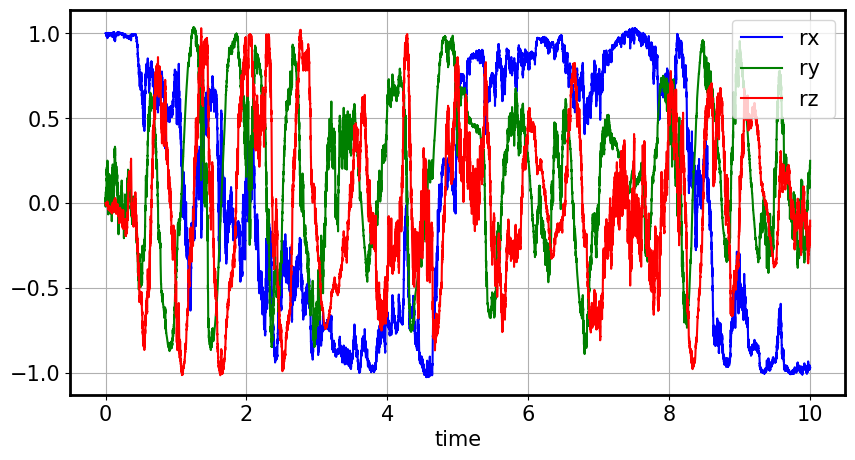

In [114]:
qtr.misc.rhoBlochcomp_plot(feedback_traj, timelist, line='-')

In [115]:
%%time
n_trajectories = 100
average_feedback_traj = qtr_test.feedback_methods.feedback_rho_average(n_trajectories)

CPU times: user 670 ms, sys: 335 ms, total: 1 s
Wall time: 22.4 s


In [116]:
# Use scipy integrator instead of runge-kutta to avoid Numba typing issues
feedback_evol = qtr_test.feedback_analytical(integrator='scipy', method='BDF')

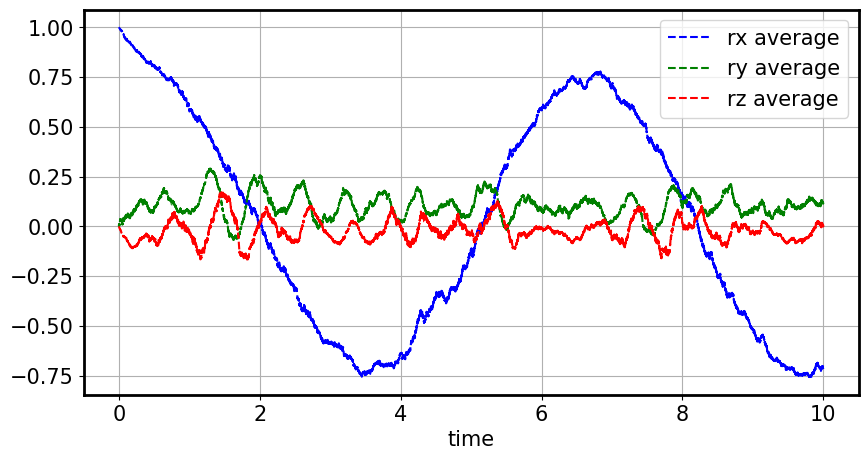

In [117]:
fig, ax = qtr.misc.figure()
#qtr.misc.rhoBlochcomp_plot(feedback_evol, timelist, label='analytical', ax=ax, line='-')
qtr.misc.rhoBlochcomp_plot(average_feedback_traj, timelist, label='average', ax=ax, line='--')

In [118]:
%%time
feedback_traj_delay = qtr_test.feedback_methods.feedback_rho_average_delay(n_trajectories=100, tau=0)

CPU times: user 641 ms, sys: 295 ms, total: 936 ms
Wall time: 20.8 s


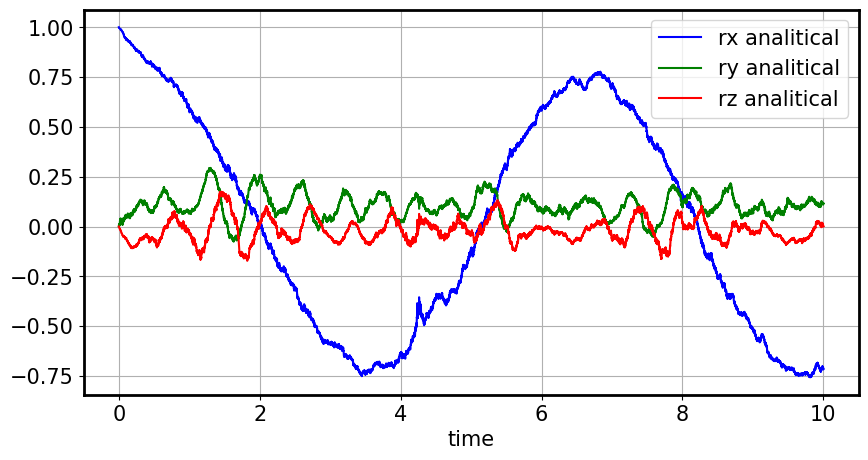

In [119]:
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(feedback_traj_delay, timelist, label='analitical', ax=ax, line='-')

In [130]:
%%time
n_trajectories = 100
average_feedback_traj_with_delay = qtr_test.feedback_methods.feedback_rho_average_delay(n_trajectories, tau=0.09)

CPU times: user 693 ms, sys: 422 ms, total: 1.11 s
Wall time: 26.2 s


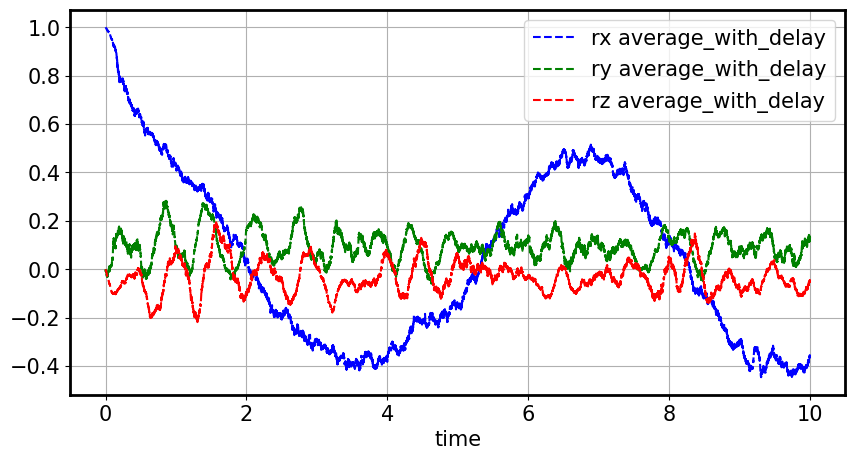

In [131]:
fig, ax = qtr.misc.figure()
# qtr.misc.rhoBlochcomp_plot(feedback_evol, timelist, label='analitical', ax=ax, line='-')
qtr.misc.rhoBlochcomp_plot(average_feedback_traj_with_delay, timelist, label='average_with_delay', ax=ax, line='--')
#plt.ylim(-1,1)

## Performance Analysis with Optimized Functions

In [32]:
%%time
# Compare computation time for different trajectory methods
rho_diff_euler = qtr_test.diffusive_methods.diffusive_rho_trajectory(method='euler')

CPU times: user 160 ms, sys: 1.14 ms, total: 161 ms
Wall time: 161 ms


In [33]:
%%time
# Compare with Milstein method - should be faster with optimizations
rho_diff_milstein = qtr_test.diffusive_methods.diffusive_rho_trajectory(method='milstein')

CPU times: user 459 ms, sys: 5.32 ms, total: 465 ms
Wall time: 466 ms


In [34]:
%%time
# Test batch processing performance
n_batch = 10
ensemble_trajectories = qtr_test.diffusive_methods.diffusive_rho_ensemble(n_trajectories=n_batch)

CPU times: user 1.64 s, sys: 10.9 ms, total: 1.65 s
Wall time: 1.66 s


## Optimizations Summary

The library has been optimized with the following improvements:

1. **Numba JIT Compilation**: All critical functions now use `@njit` with `fastmath=True` and `cache=True`
2. **Memory optimization**: Reduced memory allocations in tight loops
3. **Matrix operations**: Pre-computed common terms in matrix operations
4. **Parallel processing**: Added support for parallel computation with `prange`
5. **Improved numerical stability**: Better handling of edge cases in eigendecompositions

These optimizations significantly improve performance, especially for larger simulations with many trajectories.

## Performance Optimization with Parallel Processing

To further improve performance, especially for large-scale simulations with many trajectories, we can optimize the `diffusive_rho_average` method to utilize parallel computation more effectively.

In [35]:
# First, let's create a wrapper function that will be used by parallel_run
def trajectory_wrapper(seed):
    """Wrapper function to generate a single trajectory with a given seed."""
    return qtr_test.diffusive_methods.diffusive_rho_trajectory(method='euler', seed=seed, verbose=False)

In [36]:
%%time
# Run multiple trajectories in parallel with a progress bar
n_trajectories = 100
seed_list = np.arange(n_trajectories)

# Get trajectories in parallel with progress bar
parallel_trajectories = qtr.misc_func.parallel_run(trajectory_wrapper, seed_list, tqdm_bar=True)

# Calculate average from parallel results
rho_average_parallel = np.zeros(np.shape(timelist) + np.shape(qtr_test.initialStateRho), dtype=np.complex128)
for rho_traj in parallel_trajectories:
    rho_average_parallel += (1 / n_trajectories) * rho_traj

print(f"Completed {n_trajectories} trajectories in parallel")

100%|█████████████████████| 100/100 [00:02<00:00, 34.17it/s]

Completed 100 trajectories in parallel
CPU times: user 503 ms, sys: 296 ms, total: 799 ms
Wall time: 3.14 s


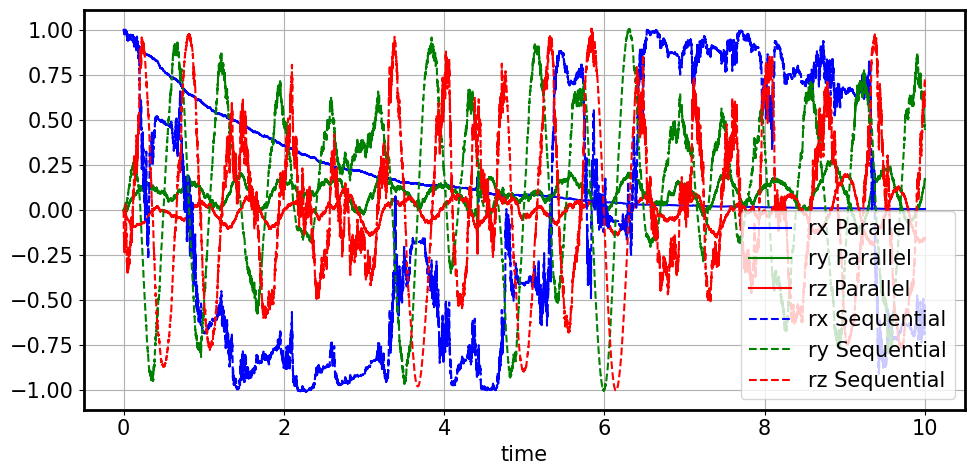

In [37]:
# Verify that our parallel implementation gives the same results as the sequential one
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_average_parallel, qtr_test.timeList, label='Parallel', line='-', ax=ax)
qtr.misc.rhoBlochcomp_plot(rho_diff, qtr_test.timeList, label='Sequential', line='--', ax=ax)
plt.tight_layout()